# Topic Modeling

## Find Topics Across Twitter for All Known State Sponsored Hackers


### 6-14-2022

- **Goal:** This attempts to discover topics for all known state sponsored hackers for which cyber security (blue team) analysts have found evidence of activity. This evidence is known to be posted to Twitter with specific hashtags related to the specific hacker.

- **Work Completed**: The first step was to grab twitter posts with specific hashtags. Since I'm familiar with the cyber security domain, I created a [known good list](https://docs.google.com/spreadsheets/d/1U8VIWzl5_Yj9uwpCuhAyerZr5niaiE5FeC4ec4Oxy_s/edit?usp=sharing) based on this correlated [list](https://github.com/StrangerealIntel/EternalLiberty/blob/main/EternalLiberty.csv) of state sponsored actors that many cyber security practitioners use for reference that would be used to query for hashtags on Twitter (i.e. #apt01). Using a trial membership to [PhantomBuster](https://phantombuster.com/), the hashtags were then queried across Twitter and all twitter posts with those hashtags were returned into a json file. Importing the json into a dataframe, EDA was performed, and then 2 methods of topic modeling were performed. The first method is based on creating a vector with TF-IDF to then be input into a NMF model to which the top 20 topics were visualized. The second method was similar to the first, but I used Gensim to generate a LDA model with a visualization using the pyLDAvis library.

- **Findings:** There's some topics that correlate well with the text. Expected outcomes of having the word like "hack" associated with certain countries makes sense. However, there were some topics that were not expected at first. Topics such as Ebay with some businesses, and insects with species identification. The latter was realized that the hashtags that were pulled included some insect names (e.g. #dragonfly) that happen to also be named as a state sponsored hacker.

### Imports

In [1]:
# ref: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction

# dataset / math / text manipulation
import pandas as pd
import re
import string

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# visuals
import pyLDAvis
# ref: https://stackoverflow.com/questions/66759852/no-module-named-pyldavis
import pyLDAvis.gensim_models

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction import text

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel

# spacy
import spacy

# warnings notitication choice
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/randy.grant/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
pd.options.display.max_columns=100
pd.options.display.max_rows=100
pd.set_option('max_colwidth', 300)

### EDA and Data Cleaning

In [3]:
# ref: https://github.com/StrangerealIntel/EternalLiberty/blob/main/EternalLiberty.csv
# ref: https://phantombuster.com/

df = pd.read_json("apt_hashtags.json")
df.drop_duplicates(inplace=True)
df['content'].dropna(inplace=True)

In [4]:
df.sample(10, random_state=42).style

,tweetDate,content,twitterProfile,tweetUrl,timestamp,query
9985,Tue May 31 13:29:13 +0000 2022,bicyclesbeyond - #CYCOLOGY 🚲 #Cycling is #oxygen for the #soul 🤩 Good morning dear #BikeFriends 🙌🏽 🚴‍♀️🚴‍♂️🚴🏻 💚 https://t.co/pen0W72I2g,https://twitter.com/SpokePedal,https://twitter.com/SpokePedal/status/1531628869630951430,2022-06-02 02:01:41.260000+00:00,#Oxygen
7476,Tue May 31 17:09:13 +0000 2022,#LAZARUS,https://twitter.com/AlohaTemple,https://twitter.com/AlohaTemple/status/1531684233143386113,2022-06-02 01:52:28.585000+00:00,#Lazarus
6867,Mon May 30 07:03:03 +0000 2022,Booking profits early is worst than booking loss I had monthly infy calls😒 #infy,https://twitter.com/shubhamwalke100,https://twitter.com/shubhamwalke100/status/1531169299984809984,2022-06-02 01:50:26.364000+00:00,#Infy
5350,Mon Oct 08 15:43:15 +0000 2018,"A wrap for today's film screening art(ist FILM, thanks to all who came & showed films for todays short films fest at Rory Gallagher Theatre. Image of #Greenbug by Thomas Spencer & Wilhelmina van der Bent, closing Programme 1 & more coming 2moro for Programme 2 the same venue @ 1. https://t.co/aQtHIVTZaW",https://twitter.com/MTUArtsOffice,https://twitter.com/MTUArtsOffice/status/1049324351781265409,2022-06-02 01:45:09.982000+00:00,#Greenbug
9669,Fri May 27 19:26:26 +0000 2022,So thrilled on the updates of #Nitro League. I'm one of the pioneers who are observing this project's direction 🚀,https://twitter.com/deborah62538044,https://twitter.com/deborah62538044/status/1530269212945817600,2022-06-02 02:00:28.015000+00:00,#Nitro
1701,Sat Oct 20 21:35:16 +0000 2018,Nice #surprise! Deployed #temperature loggers as artificial substrates for #blackfly / Simulidae #pupae in the Eulach #river https://t.co/o2ZZfZv4XK,https://twitter.com/MKuemmerlen,https://twitter.com/MKuemmerlen/status/1053761593585090562,2022-06-02 01:27:26.830000+00:00,#Blackfly
12366,Tue May 31 13:04:51 +0000 2022,🇳🇱 🇺🇸 The #Netherlands to Acquire AIM-9x Block II Missiles from #USA #sidewinder https://t.co/H0TFX9ofUs,https://twitter.com/tur_def,https://twitter.com/tur_def/status/1531622737298526208,2022-06-02 02:12:06.548000+00:00,#SideWinder
9636,Tue May 24 14:01:57 +0000 2022,"Fitted with the latest Angular Velocity Fan Blade Design & constructed in the sleek white Die Casted Aluminum-Magnesium Alloy Frame, experience increased airflow & cooler operation in a strong & scratch resistant special frame with the SAPPHIRE #NITRO+ #AMD #Radeon #RX6950XT PURE https://t.co/KQIHjs73R7",https://twitter.com/SapphireTech,https://twitter.com/SapphireTech/status/1529100392667152386,2022-06-02 02:00:25.477000+00:00,#Nitro
11200,Fri Apr 21 11:35:48 +0000 2017,"Prêt pour le #ConcertauCDI ? RV mardi prochain 25 à midi30. Dépaysement assuré, avec #RedDjinn !",https://twitter.com/CdiVilgenis,https://twitter.com/CdiVilgenis/status/855384571399024640,2022-06-02 02:07:19.553000+00:00,#RedDjinn
1586,Sun May 29 15:54:57 +0000 2022,Check out Neon Snake Skin Print Women Deep V One Piece Swimsuit High Leg Leopard Size XL https://t.co/RpKS5TN7z6 #eBay via @eBay #PitchBlack #Blackpreneur #SupportBlackBusiness #ShopBlack #BlackTech #Blackownedbusiness #Blackexcellence #Blackgirlmagic,https://twitter.com/sunfloweruluv,https://twitter.com/sunfloweruluv/status/1530940767358836738,2022-06-02 01:27:00.728000+00:00,#BlackTech


In [5]:
print(f"Number of documents:", len(df['content']))
print(f"Aggregated length of corpus:", sum([len(d.split(' ')) for d in df['content']]))

Number of documents: 12411
Aggregated length of corpus: 271026


In [6]:
# ref: https://stackoverflow.com/questions/46848209/get-the-earliest-date-from-a-column-python-pandas-after-csv-reader
print(f"Earliest Date:", pd.to_datetime(df['tweetDate']).min())
print(f"Latest Date:", pd.to_datetime(df['tweetDate']).max())

Earliest Date: 2010-08-09 13:00:05+00:00
Latest Date: 2022-06-02 02:03:47+00:00


In [7]:
# lowercase all
# ref: https://stackoverflow.com/a/50084009
df.rename(columns=str.lower, inplace=True)
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

In [8]:
# hashtag top 20 counts
df['query'].value_counts().head(20)

#butterfly     458
#monsoon       433
#mercury       427
#hades         417
#redphoenix    406
#bookworm      368
#castle        363
#dragonfly     361
#animalfarm    313
#infy          297
#nitro         270
#bitter        233
#platinum      231
#honeybee      222
#duststorm     195
#leviathan     190
#potassium     188
#safe          188
#magnesium     183
#evileye       181
Name: query, dtype: int64

In [9]:
# ref: https://machinelearningmastery.com/clean-text-machine-learning-python/
data = df['content'].to_list()

# remove new lines
data = [ re.sub('\s+', ' ', d) for d in data ]

# remove twitter short links
data = [ re.sub("https?:\/\/t.co\/([^\s+]{10})", '', d) for d in data ]

# remove punctuation
re_punc = re.compile('[%s]' % re.escape(string.punctuation))
data = [ re_punc.sub('', w) for w in data ]
print(data[:3])

['2020年3月，国内网络安全企业360公司披露了美国中央情报局背景的黑客组织aptc39自2008年起对中国实施持续长达11年之久的网络攻击活动情况，攻击目标主要集中在中国的政府部门、科研机构等，涉及航空航天、石油能源、互联网等多个重要行业。', 'voachinese chinese cyber security agencies have continuously unveiled the true features of the us national security agency nsa telescreen action aptc40 nopen and quantum cyber attack weapons the honeycomb platform is jointly developed by the subordinate departments of cia', 'reutersus chinese cyber security agencies have continuously unveiled the true features of the us national security agency nsa telescreen action aptc40 nopen and quantum cyber attack weapons the honeycomb platform is jointly developed by the subordinate departments of cia']


### Method 1: NMF and LDA without Gensim

#### Establish Word Tokens and Vectorization

In [10]:
# ref: https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list/24386751#24386751

custom_stop_words = ['cyber', 'the', 'they', 'their', 'they\'re']
stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

#### Most based on scikit learn documentation with example [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

In [11]:
n_samples = 10000
n_features = 5000
n_components = 10
n_top_words = 20

# NNDSVD with zeros filled with the average of X (better when sparsity is not desired)
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

data_samples = data[:n_samples]

In [12]:
# ref: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=.001, max_df=.95, ngram_range=(1,2), max_features=n_features)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(stop_words=stop_words, min_df=.001, max_df=.95, ngram_range=(1,2), max_features=n_features)
tf = tf_vectorizer.fit_transform(data_samples)

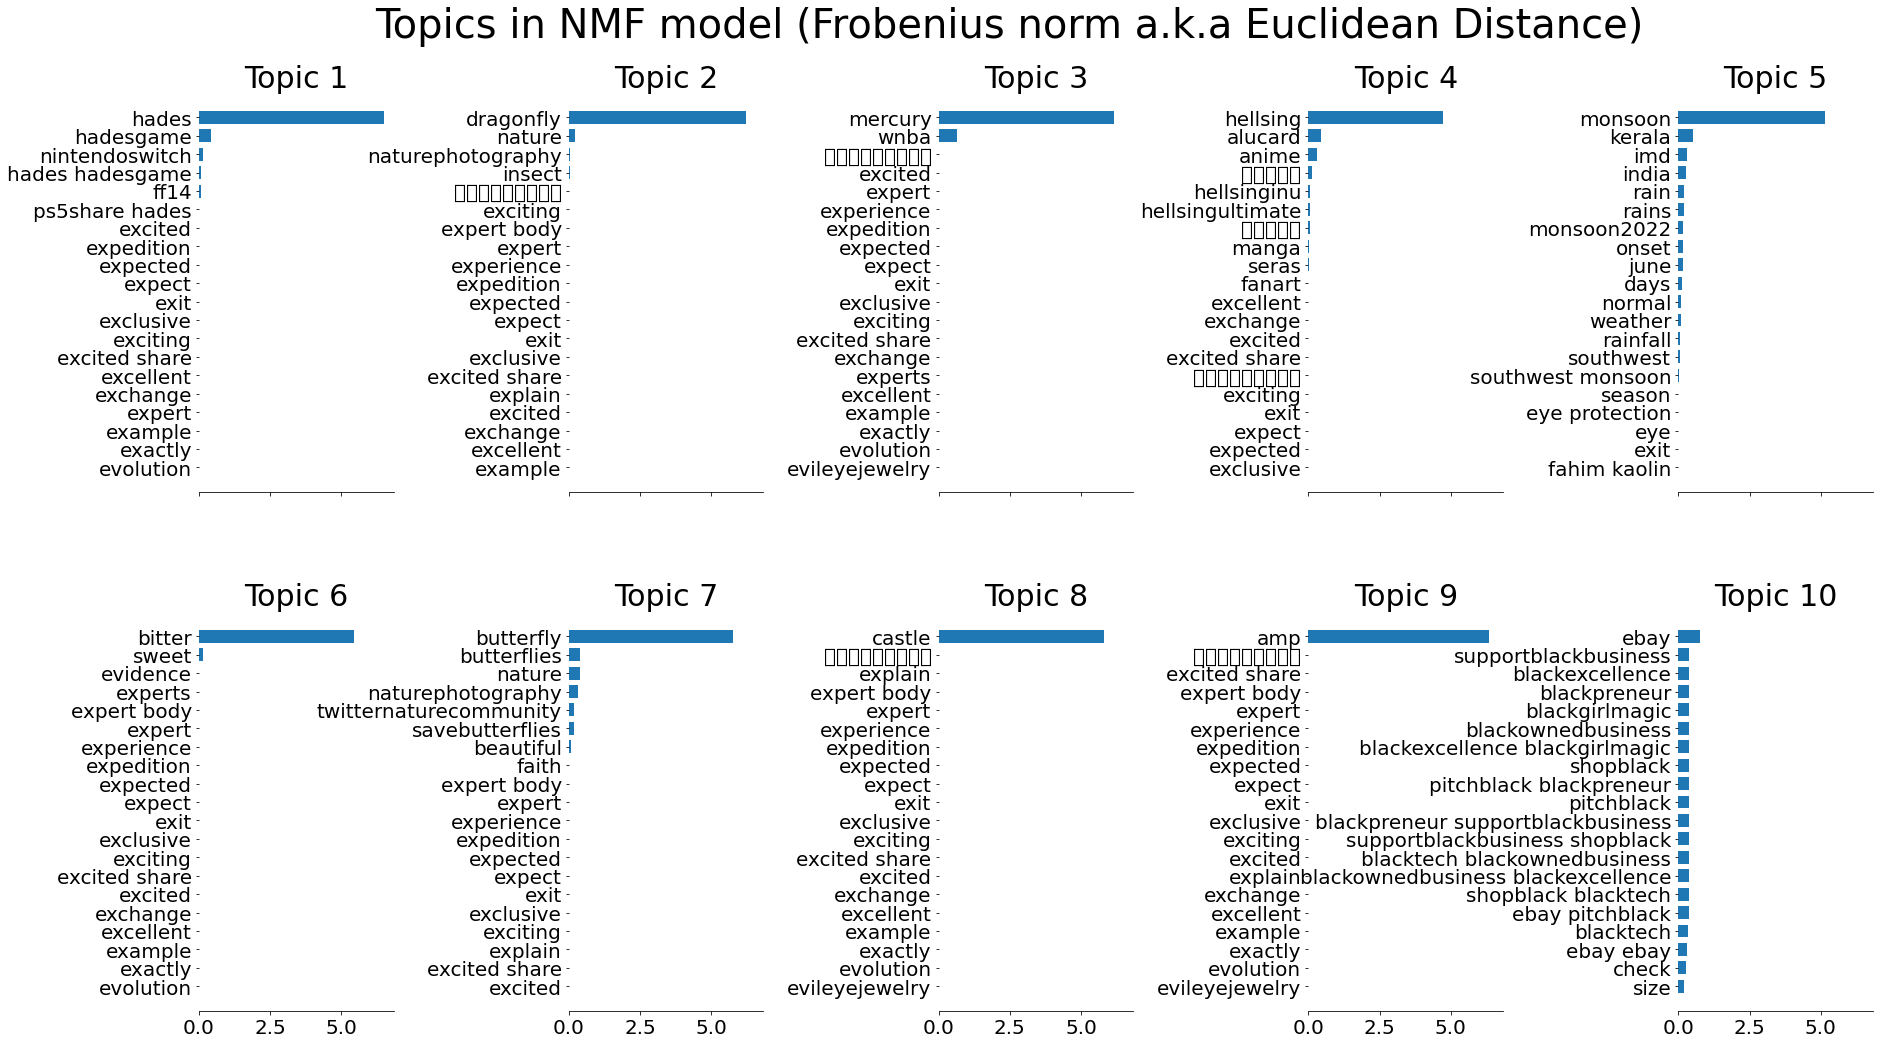

In [13]:
# Fit the NMF model with Frobenius norm
nmf = NMF(
    n_components=n_components,
    random_state=42,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm a.k.a Euclidean Distance)")

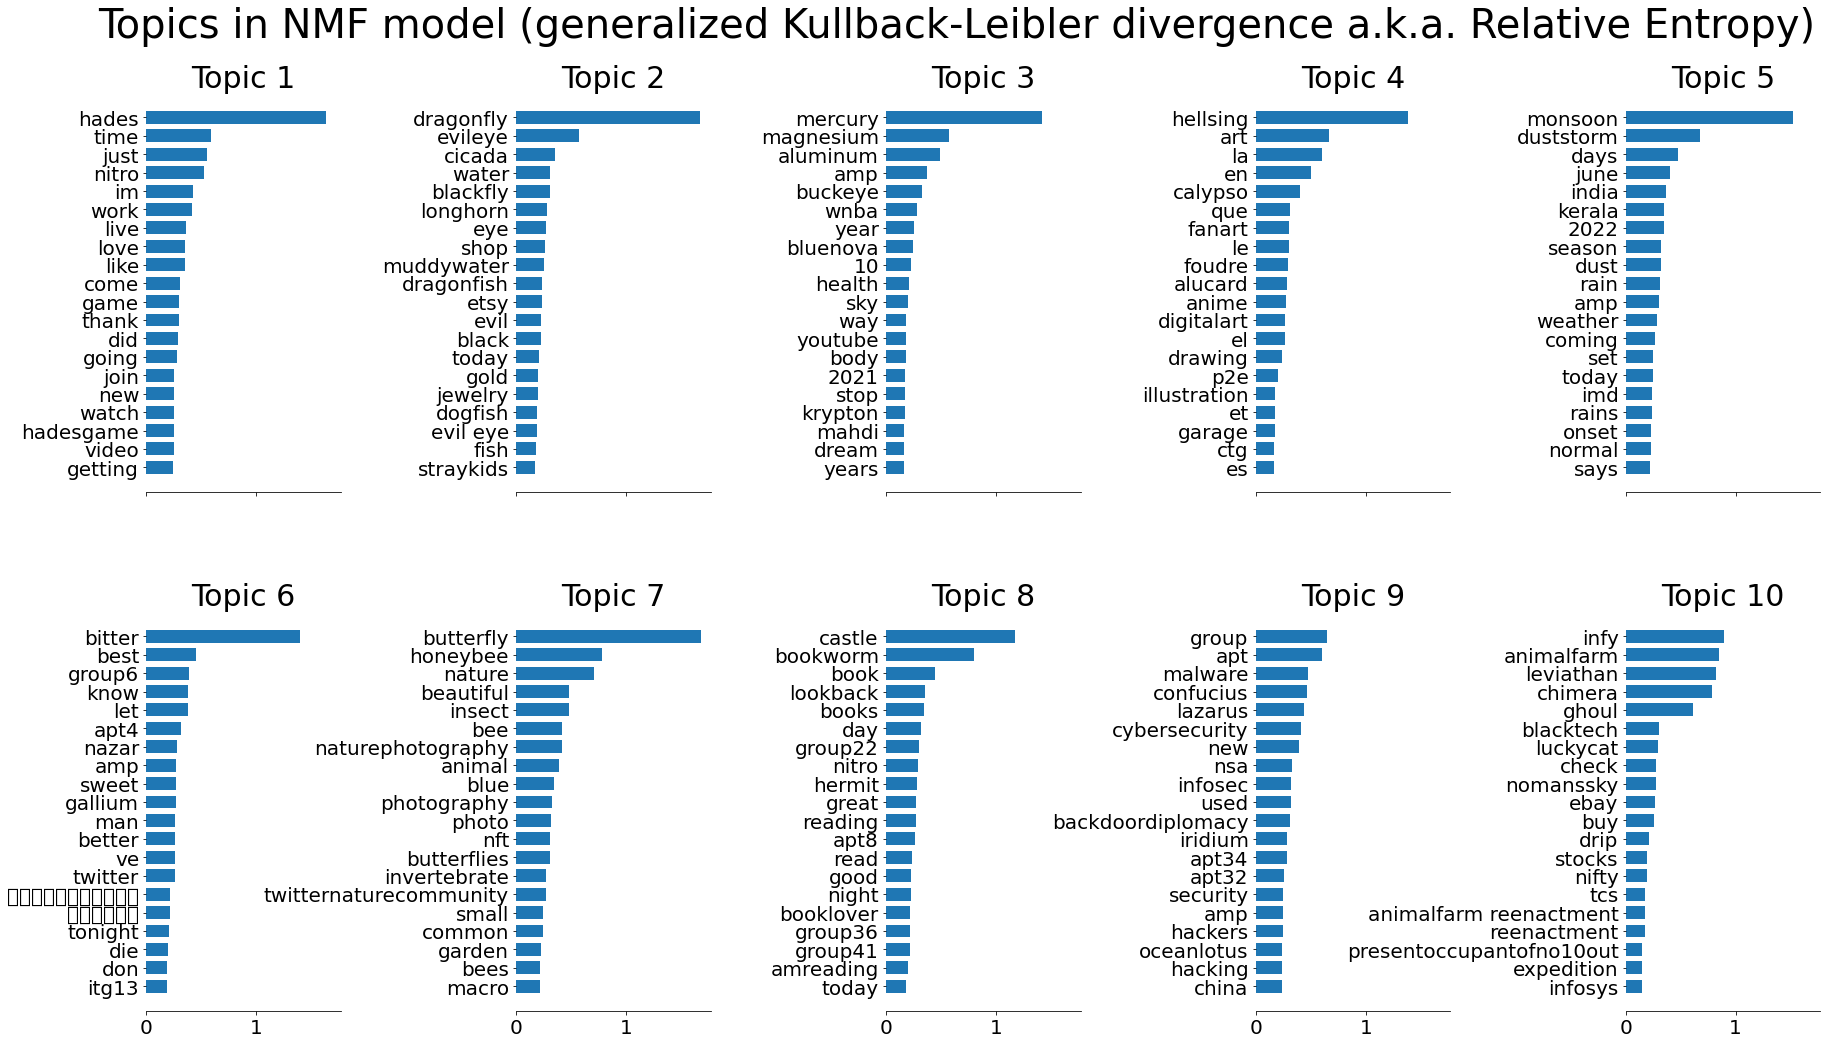

In [14]:
# Fit the NMF model with generalized Kullback-Leibler divergence
nmf = NMF(
    n_components=n_components,
    random_state=42,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=5000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence a.k.a. Relative Entropy)",
)

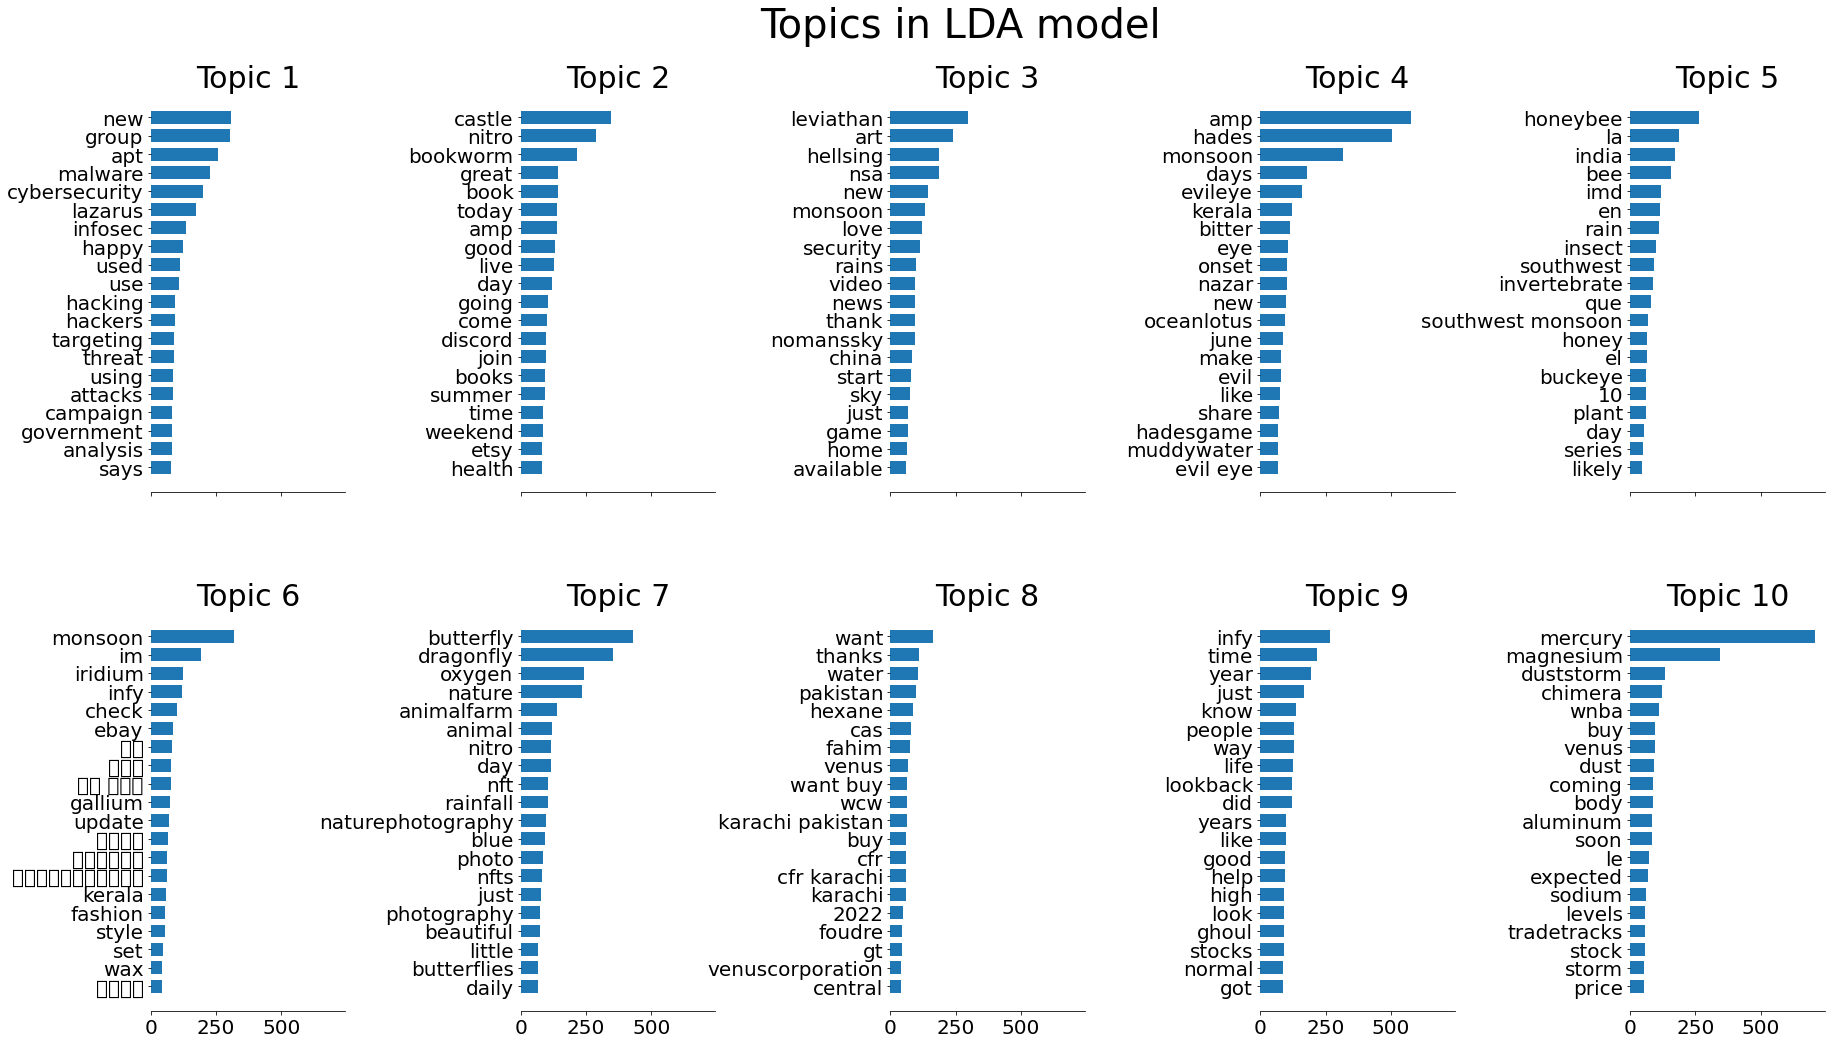

In [15]:
# Fit the LDA model
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=42,
)

lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### Method 2: Use Gensim with pyLDAvis

In [16]:
# ref: https://github.com/wjbmattingly/topic_modeling_textbook/blob/main/03_03_lda_model_demo.ipynb
# ref: https://www.youtube.com/watch?v=TKjjlp5_r7o

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(data)
print(lemmatized_texts[:10][:100])

['。', 'security agency continuously unveil true feature nsa telescreen action cyber attack weapon honeycomb platform jointly develop subordinate department', 'security agency continuously unveil true feature nsa telescreen action cyber attack weapon honeycomb platform jointly develop subordinate department', 'security agency continuously unveil true feature nsa telescreen action cyber attack weapon honeycomb platform jointly develop subordinate department', 'security agency continuously unveil true feature nsa telescreen action cyber attack weapon honeycomb platform jointly develop subordinate department', 'security agency continuously unveil true feature nsa telescreen action cyber attack weapon honeycomb platform jointly develop subordinate department', 'security agency continuously unveil true feature nsa telescreen action cyber attack weapon honeycomb platform jointly develop subordinate department', 'guilty pleasure collect apt group allegedly country usual suspect now aptc44 say 

In [17]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print(data_words[:10][:100])

[[], ['security', 'agency', 'continuously', 'unveil', 'true', 'feature', 'nsa', 'telescreen', 'action', 'cyber', 'attack', 'weapon', 'honeycomb', 'platform', 'jointly', 'develop', 'subordinate', 'department'], ['security', 'agency', 'continuously', 'unveil', 'true', 'feature', 'nsa', 'telescreen', 'action', 'cyber', 'attack', 'weapon', 'honeycomb', 'platform', 'jointly', 'develop', 'subordinate', 'department'], ['security', 'agency', 'continuously', 'unveil', 'true', 'feature', 'nsa', 'telescreen', 'action', 'cyber', 'attack', 'weapon', 'honeycomb', 'platform', 'jointly', 'develop', 'subordinate', 'department'], ['security', 'agency', 'continuously', 'unveil', 'true', 'feature', 'nsa', 'telescreen', 'action', 'cyber', 'attack', 'weapon', 'honeycomb', 'platform', 'jointly', 'develop', 'subordinate', 'department'], ['security', 'agency', 'continuously', 'unveil', 'true', 'feature', 'nsa', 'telescreen', 'action', 'cyber', 'attack', 'weapon', 'honeycomb', 'platform', 'jointly', 'develop', 

In [18]:
# ref: https://www.youtube.com/watch?v=UEn3xHNBXJU&list=PL2VXyKi-KpYttggRATQVmgFcQst3z6OlX&index=11

# make bigrams and trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[:10][0:20])

[[], ['security_agency_continuously', 'unveil_true_feature', 'nsa_telescreen', 'action', 'cyber', 'attack', 'weapon_honeycomb_platform_jointly', 'develop_subordinate_department'], ['security_agency_continuously', 'unveil_true_feature', 'nsa_telescreen', 'action', 'cyber', 'attack', 'weapon_honeycomb_platform_jointly', 'develop_subordinate_department'], ['security_agency_continuously', 'unveil_true_feature', 'nsa_telescreen', 'action', 'cyber', 'attack', 'weapon_honeycomb_platform_jointly', 'develop_subordinate_department'], ['security_agency_continuously', 'unveil_true_feature', 'nsa_telescreen', 'action', 'cyber', 'attack', 'weapon_honeycomb_platform_jointly', 'develop_subordinate_department'], ['security_agency_continuously', 'unveil_true_feature', 'nsa_telescreen', 'action', 'cyber', 'attack', 'weapon_honeycomb_platform_jointly', 'develop_subordinate_department'], ['security_agency_continuously', 'unveil_true_feature', 'nsa_telescreen', 'action', 'cyber', 'attack', 'weapon_honeycomb

In [19]:
# tf-idf
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [ id2word.doc2bow(text) for text in texts ]

# instantiate tf-idf model
tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    tfidf_ids = [ id for id, value in tfidf[bow] ]
    bow_ids = [ id for id, value in bow ]
    low_value_words = [ id for id, value in tfidf[bow] if value < low_value ]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    
    # The words with tf-idf score 0 will be missing
    words_missing_in_tfidf = [ id for id in bow_ids if id not in tfidf_ids ]

    new_bow = [ b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf ]
    corpus[i] = new_bow

#### Create LDA Model and Visualize

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
    id2word=id2word,
    num_topics=25,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=25,
    alpha="auto")

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/Users/randy.grant/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/randy.grant/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/randy.grant/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/randy.grant/opt/anaconda3/envs/unsupervised/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  fro

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.017554  0.354194       1        1  10.557407
12     0.322529 -0.038029       2        1   9.486246
15    -0.324863 -0.084211       3        1   9.302591
23     0.309497  0.188114       4        1   7.825011
18    -0.264136  0.069879       5        1   6.009458
0     -0.188206 -0.230849       6        1   5.810770
1      0.059655 -0.212914       7        1   5.528267
2     -0.186766  0.203118       8        1   5.311402
22     0.181409 -0.071516       9        1   5.124549
21     0.217091 -0.201217      10        1   4.992563
8      0.154410  0.115470      11        1   4.047507
7      0.049755  0.189154      12        1   3.971798
10     0.021416 -0.327896      13        1   3.551320
9     -0.110497 -0.084241      14        1   3.150443
5     -0.042867 -0.137048      15        1   3.148838
4     -0.112008  0.081557      16        1   2.619566
20    -0.043384  0.119631      17        1   2.238512
3      0.060033 -0.003515      18        1   1.855919
14     0.013160 -0.057204      19        1   1.163141
24     0.029828  0.067457      20        1   1.109233
11     0.013513  0.028332      21        1   1.051417
17    -0.039357  0.043080      22        1   0.973769
13    -0.112253 -0.012183      23        1   0.882056
16    -0.013012 -0.002579      24        1   0.230852
19    -0.012501  0.003416      25        1   0.057364, topic_info=         Term         Freq        Total Category  logprob  loglift
292      safe  2165.000000  2165.000000  Default  30.0000  30.0000
58        new  1927.000000  1927.000000  Default  29.0000  29.0000
369       get  1728.000000  1728.000000  Default  28.0000  28.0000
10        apt  1966.000000  1966.000000  Default  27.0000  27.0000
57       more  1440.000000  1440.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
23   pleasure     0.002849    37.627892  Topic25 -10.1712  -2.0251
24        say     0.002849   482.820240  Topic25 -10.1712  -4.5770
25      share     0.002849   306.255936  Topic25 -10.1712  -4.1217
26    suspect     0.002849    60.289768  Topic25 -10.1712  -2.4965
27      usual     0.002849     2.194165  Topic25 -10.1712   0.8169

[1110 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0        23  0.826638    action
487       3  0.988938    active
510       6  0.991318  activity
130      11  0.994278     actor
495       8  0.881196   address
...     ...       ...       ...
345      17  0.925485    window
376       7  0.983515      wish
93       16  0.961896     write
331       2  0.998540      year
355       2  0.993318       yet

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 13, 16, 24, 19, 1, 2, 3, 23, 22, 9, 8, 11, 10, 6, 5, 21, 4, 15, 25, 12, 18, 14, 17, 20])